##### Datos del sujeto P001 en la sesion TEST01

In [102]:
import pandas as pd

# Cargar los datos en un DataFrame
df_P001_EDA_PPT= pd.read_csv('TEST01/E4/P001/EDA_PPT.csv')
df_P001_EDA_RELAX= pd.read_csv('TEST01/E4/P001/EDA_RELAX.csv')


# Mostrar las primeras filas del DataFrame para verificar la carga
df_P001_EDA_PPT.head() 


Time (s)      EDA
0     0.139  0.17678
1     0.389  0.17934
2     0.639  0.17550
3     0.889  0.17550
4     1.139  0.17678

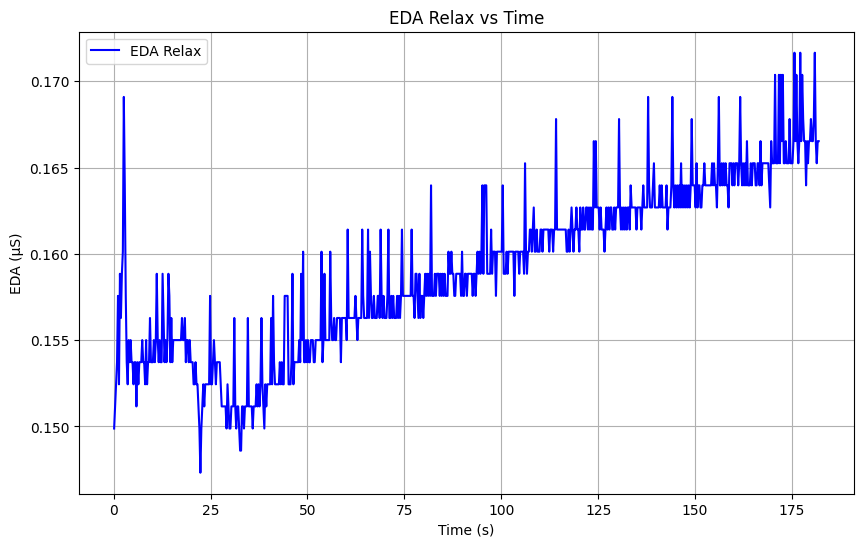

In [103]:
import pandas as pd
import matplotlib.pyplot as plt


# Extraer la columna de tiempo de df_P001_EDA_PPT
time = df_P001_EDA_PPT['Time (s)']

# Extraer la columna EDA de df_P001_EDA_RELAX
eda_relax = df_P001_EDA_RELAX['EDA']

# Asegurarse de que time y eda_relax tengan la misma longitud
min_length = min(len(time), len(eda_relax))
time = time[:min_length]
eda_relax = eda_relax[:min_length]

# Graficar EDA_RELAX contra el tiempo
plt.figure(figsize=(10, 6))
plt.plot(time, eda_relax, label='EDA Relax', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('EDA (μS)')
plt.title('EDA Relax vs Time')
plt.legend()
plt.grid(True)
plt.show()

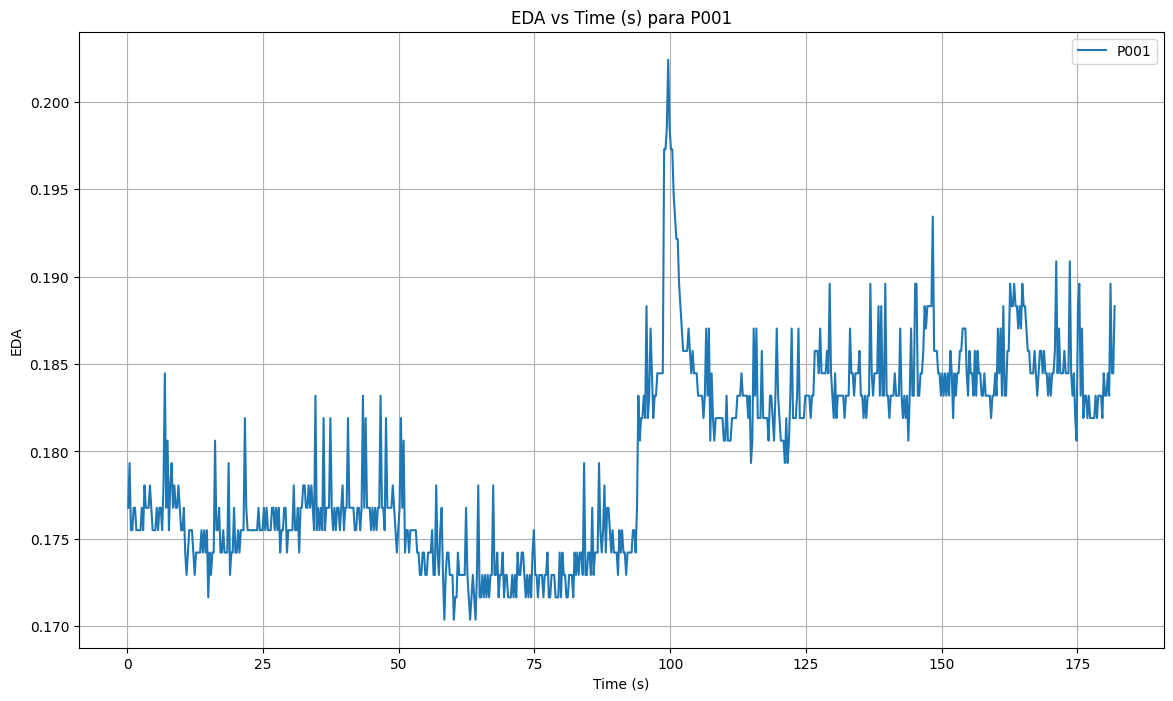

In [104]:
import matplotlib.pyplot as plt

# Graficar EDA vs Time (s) para df_P001_EDA_PPT
plt.figure(figsize=(14, 8))
plt.plot(df_P001_EDA_PPT['Time (s)'], df_P001_EDA_PPT['EDA'], label='P001')

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('EDA vs Time (s) para P001')
plt.legend()
plt.grid(True)
plt.show()

#### Proceso de desconvolución de las señal

Las señales EDA se componen de dos señales que se combinan (convolucionan), estas son:

Nivel Electrodérmico (ECL o SCL ): Es la señal de base, que varía lentamente a lo largo del tiempo.
Representa la actividad tónica de las glándulas sudoríparas, esta se puede despreciar ya que informa los cambios en la confuctancia electrodérmica en relación con la temperatura y humedad del medio ambiente o el movimiento del cuerpo.

Respuesta Electrodérmica (EDR o SCR): Es una señal que varía rápidamente y está estrechamente relacionada con el sistema nervioso simpático (SNS) encargado de preparar el cuerpo para afrontar situaciones de estres. 

Por lo tanto es necesario descomponer la señal EDA para poder aislar los datos obtenidos de señal SCR la cual varía directamente con el estres.

#### Uso de la función cvxEDA

La función `cvxEDA` es proporcionada por Luca Citi y Alberto Greco. Puedes encontrar más información en [este enlace](https://github.com/lciti/cvxEDA/tree/master).

##### Instalación de la dependencia

Para utilizar `cvxEDA`, es necesario instalar la dependencia `cvxopt`. 
Ejecutando el siguiente comando:

pip install cvxopt


     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.


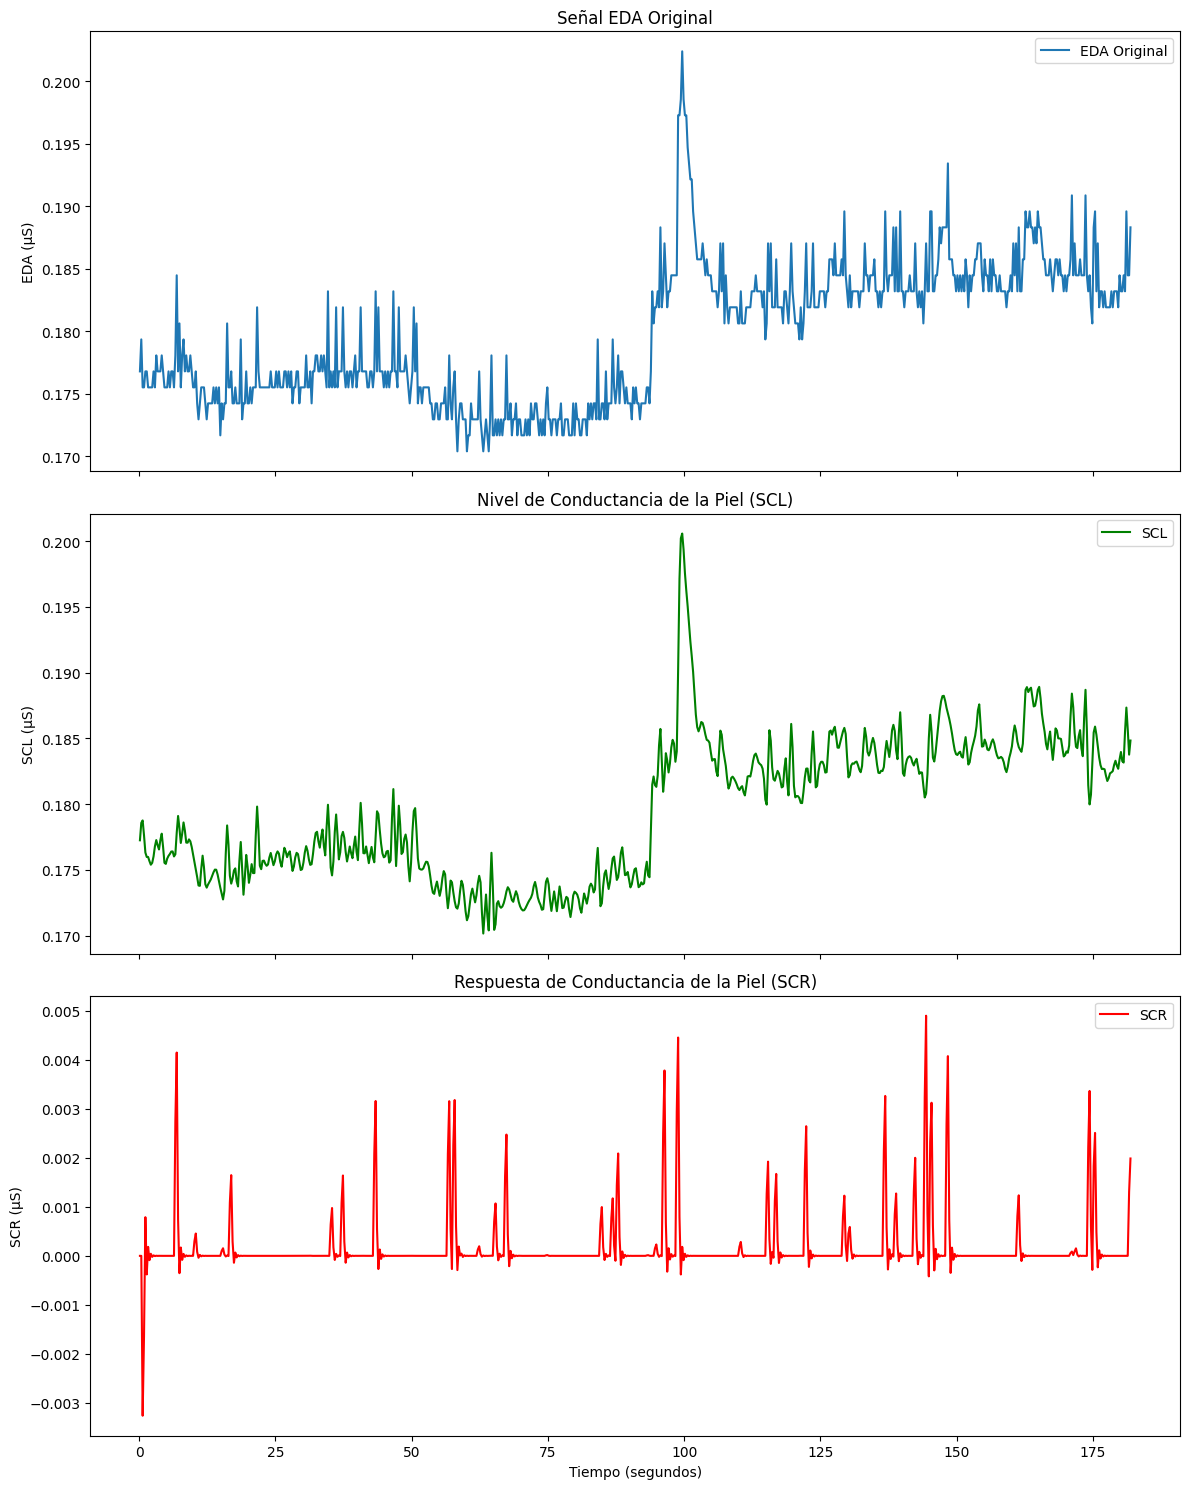

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from cvxEDA import cvxEDA

# Preparar los datos para cvxEDA
y = df_P001_EDA_PPT['EDA'].values
t = df_P001_EDA_PPT['Time (s)'].values
dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

# Realizar la desconvolución
[r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

# Crear un nuevo DataFrame con los resultados
results_P001 = pd.DataFrame({
    'time': df_P001_EDA_PPT['Time (s)'],
    'original_EDA': y,
    'SCL': t,  # Componente tónica (Skin Conductance Level)
    'SCR': r,  # Componente fásica (Skin Conductance Response)
})

# Crear la figura con tres subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Graficar EDA original
ax1.plot(results_P001['time'], results_P001['original_EDA'], label='EDA Original')
ax1.set_title('Señal EDA Original')
ax1.set_ylabel('EDA (μS)')
ax1.legend()

# Graficar SCL (componente tónica)
ax2.plot(results_P001['time'], results_P001['SCL'], label='SCL', color='green')
ax2.set_title('Nivel de Conductancia de la Piel (SCL)')
ax2.set_ylabel('SCL (μS)')
ax2.legend()

# Graficar SCR (componente fásica)
ax3.plot(results_P001['time'], results_P001['SCR'], label='SCR', color='red')
ax3.set_title('Respuesta de Conductancia de la Piel (SCR)')
ax3.set_xlabel('Tiempo (segundos)')
ax3.set_ylabel('SCR (μS)')
ax3.legend()

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

# Opcional: Guardar los resultados en un nuevo archivo CSV
results_P001.to_csv('deconvolved_EDA.csv', index=False)

#### Definición del estado como "estresado" o "no estresado"

Se consideran los reportes autodescriptivos de los participantes, como esta es la señal en el momento en que se da el discurso, se considerará el reporte TEST01_afterPPT que fue respondido luego de realizar el discurso.

Se considera el campo State Anxiety Enthusiasm Score para determinar si la persona estuvo estresada o no durante el discurso.

Por lo que es necesario definir un umbral para realizar una determinación binaria que indique si la persona estuvo estresada o no.


##### Definición del umbral de State Anxiety Enthusiasm
Gráfico de distribución de los datos.


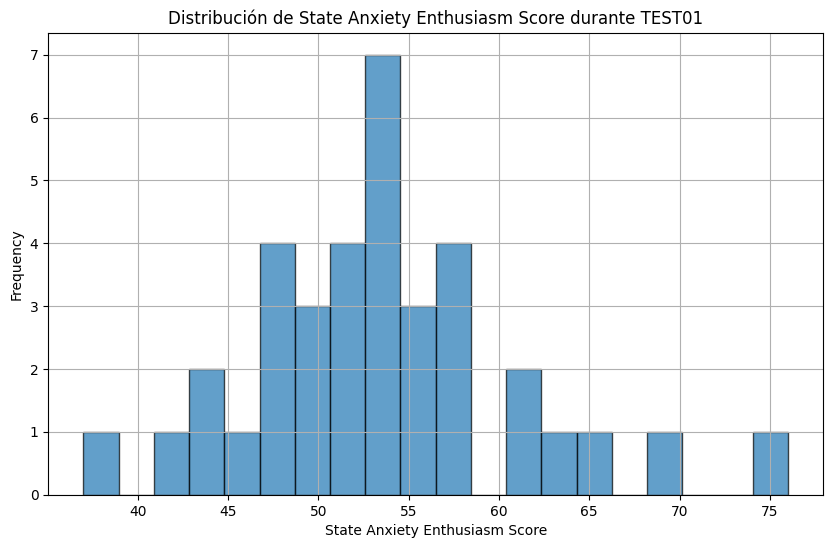

In [106]:
import pandas as pd

import matplotlib.pyplot as plt

# Cargar los datos del archivo CSV
df_self_reports = pd.read_csv('TEST01/Self_Reports/TEST01_afterPPT.csv')

# Graficar la distribución de "State Anxiety Enthusiasm Score"
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score durante TEST01') 
plt.grid(True)
plt.show()

Se calcula el rango intercuartílico (IQR), que es la diferencia entre el percentil 75 y el percentil 25. 
Esto mide la dispersión de los datos.
Si el IQR es mayor que la diferencia entre el percentil 75 y el puntaje mínimo, se selecciona el percentil 75 como umbral, lo que indica que los valores por encima de este percentil se consideran de personas no estresadas.
De lo contrario, se selecciona el percentil 25 como umbral, y los valores por debajo de este se consideran de personas estresadas.


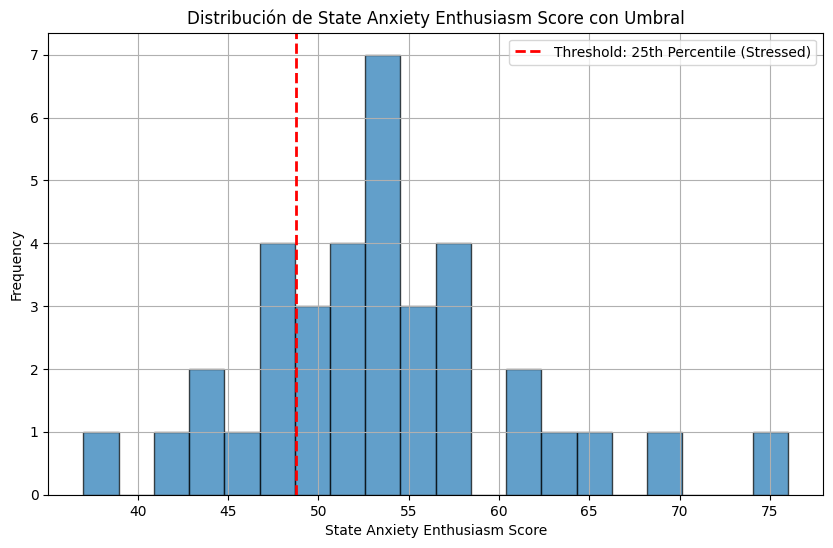

In [107]:

# Calcular los percentiles
percentile_75 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.75)
percentile_25 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.25)

# Determinar el mejor umbral basado en la dispersión de los datos
iqr = percentile_75 - percentile_25
if iqr > (percentile_75 - df_self_reports['State Anxiety Enthusiasm Score'].min()):
    best_threshold = percentile_75
    threshold_label = '75th Percentile (Non-Stressed)'
else:
    best_threshold = percentile_25
    threshold_label = '25th Percentile (Stressed)'

# Graficar la distribución con el umbral
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(best_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold_label}')
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score con Umbral')
plt.legend()
plt.grid(True)
plt.show()

Se agrega el nuevo campo stressed dependiendo si el el valor de su encuesta es superior a best_threshold se considerará como estresado

In [108]:
print(best_threshold)
# Crear una nueva columna 'stressed' basada en el umbral
df_self_reports['stressed'] = df_self_reports['State Anxiety Enthusiasm Score'].apply(lambda x: 1 if x >= best_threshold else 0)

# Crear un nuevo DataFrame con las columnas requeridas
df_stress_status = df_self_reports[['PID', 'State Anxiety Enthusiasm Score', 'stressed']]

df_stress_status.head()

48.75


PID  State Anxiety Enthusiasm Score  stressed
0  P001                              54         1
1  P004                              53         1
2  P005                              48         0
3  P008                              58         1
4  P013                              54         1

##### Considerando el umbral obtener el estado de estresado o no del participante de P001:



In [109]:
stress_P001_value = df_stress_status.loc[df_stress_status['PID'] == 'P001', 'stressed'].values[0]
print(stress_P001_value)

1


##### Segmentar la señal del participante P001 en ventanas de 30 segundos 

In [110]:
# Definir el tamaño de la ventana en segundos
window_size = 30
# Crear una columna para identificar cada ventana
results_P001['window'] = (results_P001['time'] // window_size).astype(int)

# Agrupar por ventana y calcular estadísticas
segmented_results = results_P001.groupby('window').agg({
    'time': ['min', 'max'],
    'original_EDA': ['mean', 'std'],
    'SCL': ['mean', 'std'],
    'SCR': ['mean', 'std']
}).reset_index()

# Renombrar las columnas para mayor claridad
segmented_results.columns = [
    'window', 'start_time', 'end_time', 
    'mean_original_EDA', 'std_original_EDA', 
    'mean_SCL', 'std_SCL', 
    'mean_SCR', 'std_SCR'
]

# Mostrar los resultados segmentados
segmented_results.head()

window  start_time  end_time  mean_original_EDA  std_original_EDA  \
0       0       0.139    29.889           0.175873          0.001760   
1       1      30.139    59.889           0.176247          0.002311   
2       2      60.139    89.889           0.173271          0.001712   
3       3      90.139   119.889           0.183380          0.005537   
4       4     120.139   149.889           0.184128          0.002387   

   mean_SCL   std_SCL  mean_SCR   std_SCR  
0  0.175806  0.001357  0.000059  0.000604  
1  0.176063  0.001937  0.000182  0.000625  
2  0.173173  0.001282  0.000119  0.000401  
3  0.183194  0.005330  0.000183  0.000687  
4  0.183782  0.001817  0.000344  0.000909

Agregar el valor de stressed en las ventanas:


In [111]:
segmented_results["stressed"] = stress_P001_value
segmented_results.head(1)

window  start_time  end_time  mean_original_EDA  std_original_EDA  \
0       0       0.139    29.889           0.175873           0.00176   

   mean_SCL   std_SCL  mean_SCR   std_SCR  stressed  
0  0.175806  0.001357  0.000059  0.000604         1

#### Carga de los datos de todos los participantes de la sesion TEST01 A TEST08

Se cargan los datos obtenidos de todas las pruebas cuando los participantes hablan en público y cuando se encuentran relajados.


##### Se cargan los datos de los participantes que se encuentran hablando en público.

Además se agrega la columna State Anxiety Enthusiasm Score que indica el puntaje de ansiedad o estres que sientio luego de dar la charla en público. 

In [112]:
import os
import pandas as pd

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list_EDA_PPT = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    stress_levels = pd.read_csv(f'{test_folder}/Self_Reports/{test_folder}_afterPPT.csv')
    
    for pid in pid_participants["PID"]:
        # Cargar EDA_PPT.csv
        file_path_ppt = f'{test_folder}/E4/{pid}/EDA_PPT.csv'
        # Verificar si existe el valor de "State Anxiety Enthusiasm Score" para el participante actual
        stress_level_row = stress_levels.loc[stress_levels['PID'] == pid, 'State Anxiety Enthusiasm Score']
        
        if not stress_level_row.empty:
            stress_level = stress_level_row.values[0]
        else:
            stress_level = None  # Manejar el caso donde no existe el valor
        
        if os.path.exists(file_path_ppt):
            df_pid_ppt = pd.read_csv(file_path_ppt)
            df_pid_ppt['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid_ppt['Test'] = test_folder  # Añadir una columna para identificar la prueba
            df_pid_ppt['State Anxiety Enthusiasm Score'] = stress_level  # Añadir una columna para el nivel de estrés
            df_list_EDA_PPT.append(df_pid_ppt)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_PPT = pd.concat(df_list_EDA_PPT, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
print("EDA_PPT DataFrame:")
print(df_all_tests_EDA_PPT.tail())

EDA_PPT DataFrame:
        Time (s)      EDA   PID    Test  State Anxiety Enthusiasm Score
229778   173.352  0.97374  P073  TEST08                              25
229779   173.602  0.98270  P073  TEST08                              25
229780   173.852  0.99423  P073  TEST08                              25
229781   174.102  0.98526  P073  TEST08                              25
229782   174.352  0.99167  P073  TEST08                              25


##### Se cargan los datos de los participantes que se encuentran en un estado de relajación.

In [113]:
import os
import pandas as pd

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list_EDA_RELAX = []
for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    
    for pid in pid_participants["PID"]:
        # Cargar EDA_RELAX.csv
        file_path_relax = f'{test_folder}/E4/{pid}/EDA_RELAX.csv'
        if os.path.exists(file_path_relax):
            df_pid_relax = pd.read_csv(file_path_relax)
            df_pid_relax['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid_relax['Test'] = test_folder  # Añadir una columna para identificar la prueba
            
            df_list_EDA_RELAX.append(df_pid_relax)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_RELAX = pd.concat(df_list_EDA_RELAX, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
print("EDA_RELAX DataFrame:")
print(df_all_tests_EDA_RELAX.to_string())

C:\Users\SCP-866\AppData\Local\Temp\ipykernel_16980\3150667385.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_tests_EDA_RELAX = pd.concat(df_list_EDA_RELAX, ignore_index=True)


EDA_RELAX DataFrame:
            EDA   PID    Test
0      0.149880  P001  TEST01
1      0.151161  P001  TEST01
2      0.152442  P001  TEST01
3      0.153723  P001  TEST01
4      0.157566  P001  TEST01
5      0.152442  P001  TEST01
6      0.158847  P001  TEST01
7      0.156285  P001  TEST01
8      0.158847  P001  TEST01
9      0.160128  P001  TEST01
10     0.169095  P001  TEST01
11     0.163971  P001  TEST01
12     0.157566  P001  TEST01
13     0.153723  P001  TEST01
14     0.152442  P001  TEST01
15     0.155004  P001  TEST01
16     0.153723  P001  TEST01
17     0.155004  P001  TEST01
18     0.153723  P001  TEST01
19     0.153723  P001  TEST01
20     0.152442  P001  TEST01
21     0.153723  P001  TEST01
22     0.153723  P001  TEST01
23     0.151161  P001  TEST01
24     0.153723  P001  TEST01
25     0.152442  P001  TEST01
26     0.153723  P001  TEST01
27     0.153723  P001  TEST01
28     0.153723  P001  TEST01
29     0.155004  P001  TEST01
30     0.153723  P001  TEST01
31     0.153723  P0

In [114]:
import pandas as pd

# Filtrar el DataFrame para incluir solo filas con PID igual a P001
df_p001 = df_all_tests_EDA_RELAX[df_all_tests_EDA_RELAX['PID'] == 'P001']

# Obtener una lista de los tests únicos
unique_tests = [f'TEST0{i}' for i in range(1, 10)]

# Seleccionar una fila para cada test único
sampled_data = df_p001[df_p001['Test'].isin(unique_tests)].groupby('Test').head(1)

# Mostrar los datos seleccionados
print(sampled_data)

       EDA   PID    Test
0  0.14988  P001  TEST01


##### Calcular la columna de tiempo en el estado de relajación

Dado que la frecuencia de muestreo es de 4Hz se puede calcular el tiempo en segundos


In [115]:
import pandas as pd

# Asumiendo que df_all_tests_EDA_RELAX ya está definido
# Frecuencia de muestreo en Hz
sampling_frequency = 4

# Crear una columna de tiempo que se reinicia para cada PID
df_all_tests_EDA_RELAX['Time (s)'] = df_all_tests_EDA_RELAX.groupby('PID').cumcount() / sampling_frequency

# Mostrar las primeras filas del DataFrame para verificar
df_all_tests_EDA_RELAX.head()


EDA   PID    Test  Time (s)
0  0.149880  P001  TEST01      0.00
1  0.151161  P001  TEST01      0.25
2  0.152442  P001  TEST01      0.50
3  0.153723  P001  TEST01      0.75
4  0.157566  P001  TEST01      1.00

Contabilizar la cantidad de participantes

In [116]:
unique_pid_count = pid_participants['PID'].nunique()
print(f"Cantidad de PID diferentes: {unique_pid_count}")
df_all_tests_EDA_PPT.head(3)


Cantidad de PID diferentes: 29


Time (s)      EDA   PID    Test  State Anxiety Enthusiasm Score
0     0.139  0.17678  P001  TEST01                              54
1     0.389  0.17934  P001  TEST01                              54
2     0.639  0.17550  P001  TEST01                              54

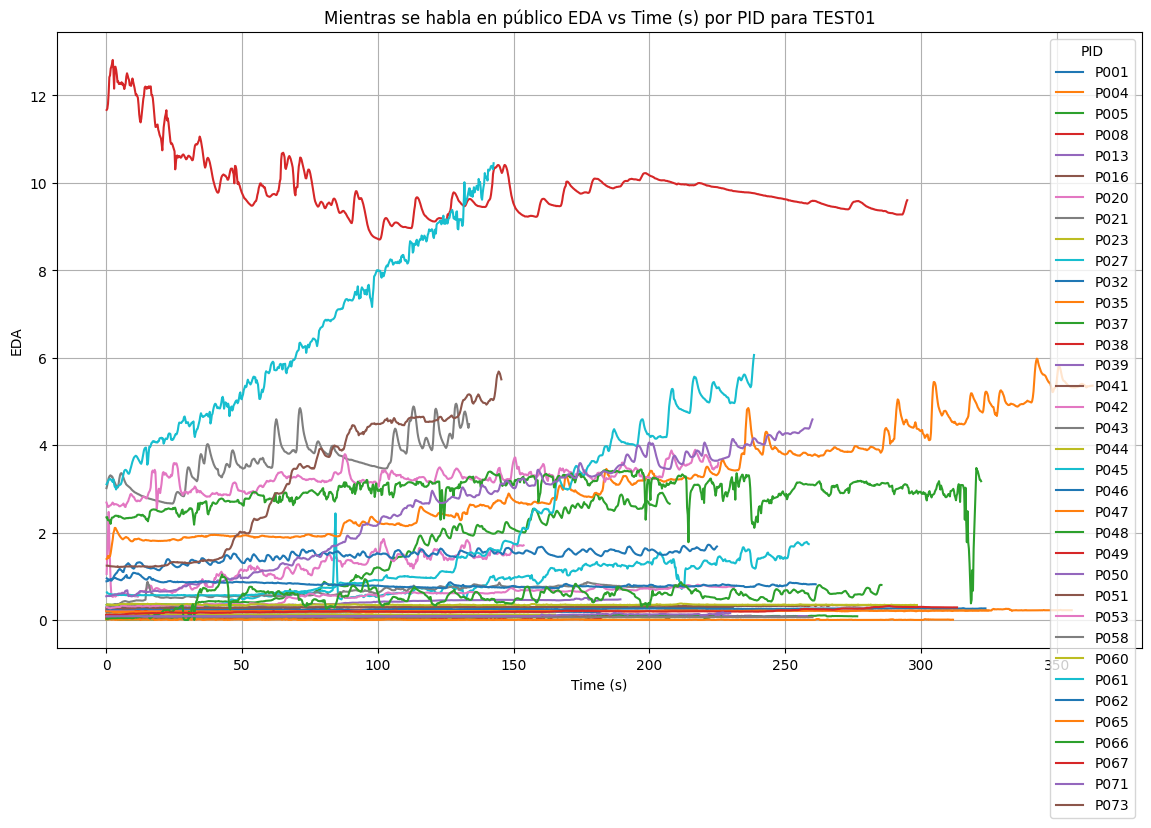

In [117]:
import matplotlib.pyplot as plt

# Filtrar los datos para incluir solo TEST01
df_test01_EDA_PPT = df_all_tests_EDA_PPT[df_all_tests_EDA_PPT['Test'] == 'TEST01']

# Graficar EDA vs Time (s) por PID para TEST01
plt.figure(figsize=(14, 8))

# Obtener los PIDs únicos para TEST01
unique_pids_test01 = df_test01_EDA_PPT['PID'].unique()

# Graficar cada PID con un color diferente
for pid in unique_pids_test01:
    df_pid = df_test01_EDA_PPT[df_test01_EDA_PPT['PID'] == pid]
    plt.plot(df_pid['Time (s)'], df_pid['EDA'], label=pid)

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('Mientras se habla en público EDA vs Time (s) por PID para TEST01')
plt.legend(title='PID')
plt.grid(True)
plt.show()

##### Agregar la columna de nivel de estres dado la encuesta en cada test.


In [118]:
import os
import pandas as pd

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list_EDA_PPT = []
df_list_self_reports = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    
    for pid in pid_participants["PID"]:
        # Cargar EDA_PPT.csv
        file_path_ppt = f'{test_folder}/E4/{pid}/EDA_PPT.csv'
        if os.path.exists(file_path_ppt):
            df_pid_ppt = pd.read_csv(file_path_ppt)
            df_pid_ppt['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid_ppt['Test'] = test_folder  # Añadir una columna para identificar la prueba
            df_list_EDA_PPT.append(df_pid_ppt)
    
    # Cargar Self_Reports CSV
    file_path_self_reports = f'{test_folder}/Self_Reports/{test_folder}_afterPPT.csv'
    if os.path.exists(file_path_self_reports):
        df_self_reports = pd.read_csv(file_path_self_reports)
        df_list_self_reports.append(df_self_reports)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_PPT = pd.concat(df_list_EDA_PPT, ignore_index=True)
df_all_self_reports = pd.concat(df_list_self_reports, ignore_index=True)

# Merge the State Anxiety Enthusiasm Score into df_all_tests_EDA_PPT

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
print("EDA_PPT DataFrame with State Anxiety Enthusiasm Score:")
print(df_all_tests_EDA_PPT.head())

EDA_PPT DataFrame with State Anxiety Enthusiasm Score:
   Time (s)      EDA   PID    Test
0     0.139  0.17678  P001  TEST01
1     0.389  0.17934  P001  TEST01
2     0.639  0.17550  P001  TEST01
3     0.889  0.17550  P001  TEST01
4     1.139  0.17678  P001  TEST01


##### Desconvolucion de todos los datos de TEST01

In [119]:

from cvxEDA import cvxEDA

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list_EDA_PPT = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    stress_levels = pd.read_csv(f'{test_folder}/Self_Reports/{test_folder}_afterPPT.csv')
    
    for pid in pid_participants["PID"]:
        # Cargar EDA_PPT.csv
        file_path_ppt = f'{test_folder}/E4/{pid}/EDA_PPT.csv'
        # Verificar si existe el valor de "State Anxiety Enthusiasm Score" para el participante actual
        stress_level_row = stress_levels.loc[stress_levels['PID'] == pid, 'State Anxiety Enthusiasm Score']
        
        if not stress_level_row.empty:
            stress_level = stress_level_row.values[0]
        else:
            stress_level = None  # Manejar el caso donde no existe el valor
        
        if os.path.exists(file_path_ppt):
            df_pid_ppt = pd.read_csv(file_path_ppt)
            df_pid_ppt['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid_ppt['Test'] = test_folder  # Añadir una columna para identificar la prueba
            df_pid_ppt['State Anxiety Enthusiasm Score'] = stress_level  # Añadir una columna para el nivel de estrés
            df_list_EDA_PPT.append(df_pid_ppt)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_PPT = pd.concat(df_list_EDA_PPT, ignore_index=True)

# Crear una lista para almacenar los resultados de cada PID y Test
results_list = []

# Obtener las combinaciones únicas de PID y Test
unique_combinations = df_all_tests_EDA_PPT[['PID', 'Test']].drop_duplicates()

# Realizar la desconvolución para cada combinación de PID y Test y almacenar los resultados
for _, row in unique_combinations.iterrows():
    pid = row['PID']
    test = row['Test']
    df_pid_test = df_all_tests_EDA_PPT[(df_all_tests_EDA_PPT['PID'] == pid) & (df_all_tests_EDA_PPT['Test'] == test)]
    
    # Preparar los datos para cvxEDA
    y = df_pid_test['EDA'].values
    t = df_pid_test['Time (s)'].values
    dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

    # Realizar la desconvolución
    [r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

    # Obtener el nivel de estrés
    stress_level = df_pid_test['State Anxiety Enthusiasm Score'].iloc[0]

    # Crear un nuevo DataFrame con los resultados
    results = pd.DataFrame({
        'time': df_pid_test['Time (s)'],
        'original_EDA': y,
        'SCL': t,  # Componente tónica (Skin Conductance Level)
        'SCR': r,  # Componente fásica (Skin Conductance Response)
        'PID': pid,  # Añadir una columna para identificar el PID
        'Test': test,  # Añadir una columna para identificar el Test
        'Stress_Level': stress_level  # Añadir una columna para el nivel de estrés
    })
    
    # Añadir los resultados a la lista
    results_list.append(results)

# Concatenar todos los resultados en un solo DataFrame
all_results_EDA_PPT = pd.concat(results_list, ignore_index=True)


     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0233e+01 -2.9092e+01  1e+03  4e+01  4e-01
 1: -2.9127e+01 -8.8761e+01  6e+01  2e+00  2e-02
 2: -2.9121e+01 -3.1459e+01  2e+00  3e-02  3e-04
 3: -2.9902e+01 -3.0237e+01  3e-01  3e-04  3e-06
 4: -3.0204e+01 -3.0232e+01  3e-02  3e-05  3e-07
 5: -3.0227e+01 -3.0232e+01  5e-03  3e-07  3e-09
 6: -3.0231e+01 -3.0232e+01  9e-04  3e-08  3e-10
 7: -3.0231e+01 -3.0231e+01  1e-04  2e-09  1e-1

In [120]:
all_results_EDA_PPT.head()

time  original_EDA       SCL       SCR   PID    Test  Stress_Level
0  0.139       0.17678  0.177249  0.000000  P001  TEST01            54
1  0.389       0.17934  0.178575  0.000000  P001  TEST01            54
2  0.639       0.17550  0.178761 -0.003261  P001  TEST01            54
3  0.889       0.17550  0.177624 -0.001637  P001  TEST01            54
4  1.139       0.17678  0.176315  0.000788  P001  TEST01            54

Procedimiento para el estado relajado:

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxEDA import cvxEDA

# Crear una lista para almacenar los resultados de cada PID y Test
results_list = []

# Obtener las combinaciones únicas de PID y Test
unique_combinations_RELAX= df_all_tests_EDA_RELAX[['PID', 'Test']].drop_duplicates()

# Realizar la desconvolución para cada combinación de PID y Test y almacenar los resultados
for _, row in unique_combinations_RELAX.iterrows():
    pid = row['PID']
    test = row['Test']
    df_pid_test_relax = df_all_tests_EDA_RELAX[(df_all_tests_EDA_RELAX['PID'] == pid) & (df_all_tests_EDA_RELAX['Test'] == test)]
    
    # Preparar los datos para cvxEDA
    y = df_pid_test_relax['EDA'].values
    t = df_pid_test_relax['Time (s)'].values
    dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

    # Realizar la desconvolución
    [r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

    # Crear un nuevo DataFrame con los resultados
    results = pd.DataFrame({
        'time': df_pid_test_relax['Time (s)'],
        'original_EDA': y,
        'SCL': t,  # Componente tónica (Skin Conductance Level)
        'SCR': r,  # Componente fásica (Skin Conductance Response)
        'PID': pid,  # Añadir una columna para identificar el PID
        'Test': test  # Añadir una columna para identificar el Test
    })
    
    # Añadir los resultados a la lista
    results_list.append(results)

# Concatenar todos los resultados en un solo DataFrame
all_results_EDA_RELAX = pd.concat(results_list, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
all_results_EDA_RELAX.head(3)

# Opcional: Guardar los resultados en un nuevo archivo CSV
# all_results.to_csv('deconvolved_EDA_all_PIDs_Tests.csv', index=False)

     pcost       dcost       gap    pres   dres
 0: -1.4706e+01 -1.3822e+01  1e+03  3e+01  5e-01
 1: -1.3846e+01 -5.9411e+01  5e+01  1e+00  2e-02
 2: -1.3843e+01 -1.5492e+01  2e+00  2e-02  4e-04
 3: -1.4489e+01 -1.4708e+01  2e-01  2e-04  4e-06
 4: -1.4678e+01 -1.4705e+01  3e-02  3e-05  5e-07
 5: -1.4701e+01 -1.4705e+01  5e-03  3e-07  5e-09
 6: -1.4704e+01 -1.4705e+01  1e-03  5e-08  8e-10
 7: -1.4705e+01 -1.4705e+01  1e-04  2e-09  3e-11
 8: -1.4705e+01 -1.4705e+01  1e-05  1e-10  2e-12
 9: -1.4705e+01 -1.4705e+01  5e-07  4e-12  5e-14
10: -1.4705e+01 -1.4705e+01  2e-08  9e-14  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.6268e+00 -3.6868e+00  1e+03  3e+01  9e-01
 1: -3.7123e+00 -5.2185e+01  5e+01  1e+00  4e-02
 2: -3.7099e+00 -5.6001e+00  2e+00  3e-02  8e-04
 3: -4.3630e+00 -4.6306e+00  3e-01  3e-04  8e-06
 4: -4.6013e+00 -4.6268e+00  3e-02  3e-05  8e-07
 5: -4.6219e+00 -4.6263e+00  4e-03  3e-06  8e-08
 6: -4.6247e+00 -4.6260e+00  1e-03  3e-08  8e-1

time  original_EDA       SCL       SCR   PID    Test
0  0.00      0.149880  0.149231  0.000000  P001  TEST01
1  0.25      0.151161  0.152181  0.000000  P001  TEST01
2  0.50      0.152442  0.155170 -0.002728  P001  TEST01

Comparación entre niveles de EDA mientras habla en público y mientras esta relajado en el participante P001 durante el TEST01.

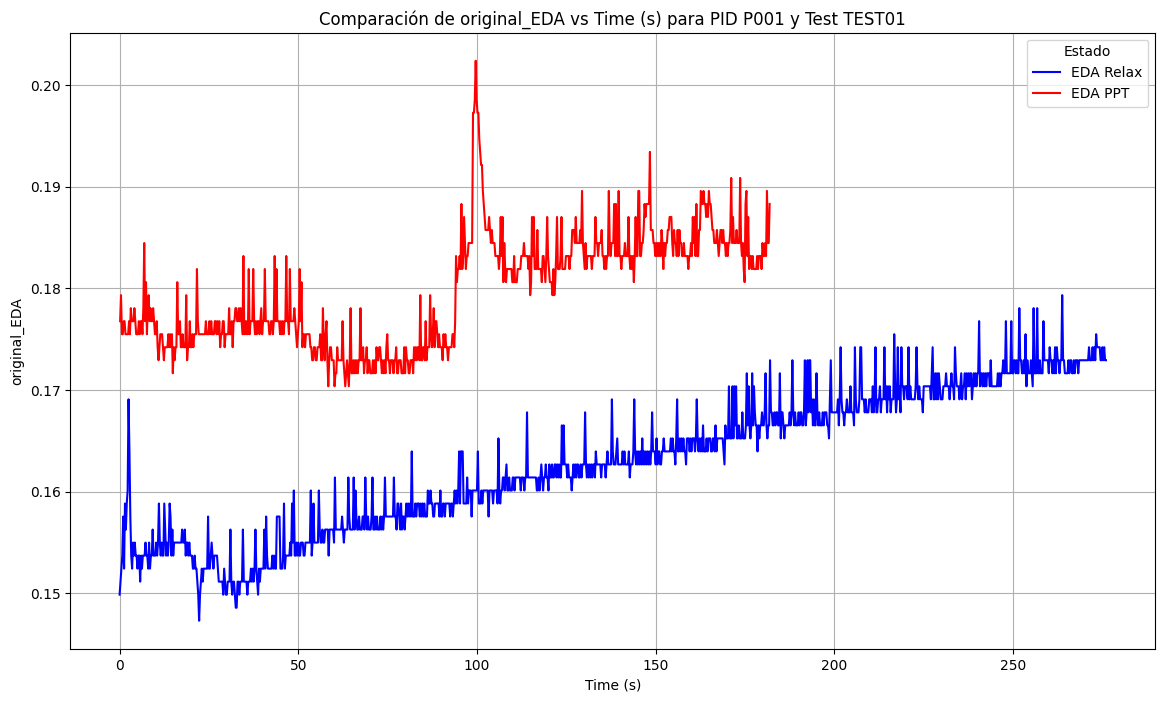

In [122]:
import matplotlib.pyplot as plt

# Filtrar los datos para incluir solo PID P001 y Test TEST01
df_relax_p001_test01 = all_results_EDA_RELAX[(all_results_EDA_RELAX['PID'] == 'P001') & (all_results_EDA_RELAX['Test'] == 'TEST01')]
df_ppt_p001_test01 = all_results_EDA_PPT[(all_results_EDA_PPT['PID'] == 'P001') & (all_results_EDA_PPT['Test'] == 'TEST01')]

# Graficar la comparación de original_EDA vs time para PID P001 y Test TEST01
plt.figure(figsize=(14, 8))

# Graficar original_EDA para el estado de relajación
plt.plot(df_relax_p001_test01['time'], df_relax_p001_test01['original_EDA'], label='EDA Relax', color='blue')

# Graficar original_EDA para el estado de PPT
plt.plot(df_ppt_p001_test01['time'], df_ppt_p001_test01['original_EDA'], label='EDA PPT', color='red')

plt.xlabel('Time (s)')
plt.ylabel('original_EDA')
plt.title('Comparación de original_EDA vs Time (s) para PID P001 y Test TEST01')
plt.legend(title='Estado')
plt.grid(True)
plt.show()

##### Creacion de ventanas de  30 segundos

Además se agregan las caracteristicas :

Feature Vector = [meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery ]

In [123]:
import pandas as pd
import numpy as np

# Definir el tamaño de la ventana en segundos
window_size = 30

# Crear una columna para identificar cada ventana en all_results_EDA_RELAX
all_results_EDA_RELAX['window'] = (all_results_EDA_RELAX['time'] // window_size).astype(int)

# Crear una columna para identificar cada ventana en all_results_EDA_PPT
all_results_EDA_PPT['window'] = (all_results_EDA_PPT['time'] // window_size).astype(int)

# Función para calcular las características
def calculate_features(df):
    meanEDA = df['original_EDA'].mean()
    minEDA = df['original_EDA'].min()
    maxEDA = df['original_EDA'].max()
    stdEDA = df['original_EDA'].std()
    meanSCRonsets = df['SCR'].mean()  # Asumiendo que 'SCR' representa los onsets
    meanSCRamp = df['SCR'].max() - df['SCR'].min()  # Amplitud como diferencia entre max y min
    meanSCRrecovery = df['SCR'].mean()  # Asumiendo que 'SCR' representa la recuperación
    
    return pd.Series([meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery],
                     index=['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery'])

# Agrupar por ventana y calcular características en all_results_EDA_RELAX
segmented_results_EDA_RELAX = all_results_EDA_RELAX.groupby(['PID', 'Test', 'window']).apply(calculate_features).reset_index()

# Agrupar por ventana y calcular características en all_results_EDA_PPT
segmented_results_EDA_PPT = all_results_EDA_PPT.groupby(['PID', 'Test', 'window']).apply(calculate_features).reset_index()

# Añadir la columna Stress_Level a segmented_results_EDA_PPT
stress_levels = all_results_EDA_PPT[['PID', 'Test', 'Stress_Level']].drop_duplicates()
segmented_results_EDA_PPT = pd.merge(segmented_results_EDA_PPT, stress_levels, on=['PID', 'Test'], how='left')




C:\Users\SCP-866\AppData\Local\Temp\ipykernel_16980\3759155328.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_results_EDA_RELAX = all_results_EDA_RELAX.groupby(['PID', 'Test', 'window']).apply(calculate_features).reset_index()
C:\Users\SCP-866\AppData\Local\Temp\ipykernel_16980\3759155328.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_results_EDA_PPT = all_results_EDA_PPT.gro

Contabilizar la cantidad de ventanas

In [124]:
# Mostrar las primeras filas de los DataFrames para verificar
print("Segmented Results EDA Relax:")
print(segmented_results_EDA_RELAX.head())

print("\nSegmented Results EDA PPT:")
print(segmented_results_EDA_PPT.head())
print("Cantidad de ventanas para PPT ", len(segmented_results_EDA_PPT))
print("Cantidad de ventanas para relax ", len(segmented_results_EDA_RELAX))


Segmented Results EDA Relax:
    PID    Test  window   meanEDA    minEDA    maxEDA    stdEDA  \
0  P001  TEST01       0  0.154043  0.147318  0.169095  0.002694   
1  P001  TEST01       1  0.153755  0.148599  0.160128  0.002483   
2  P001  TEST01       2  0.157705  0.155004  0.163971  0.001538   
3  P001  TEST01       3  0.160416  0.157566  0.167814  0.001623   
4  P001  TEST01       4  0.162882  0.160128  0.169095  0.001482   

   meanSCRonsets  meanSCRamp  meanSCRrecovery  
0       0.000056    0.006032         0.000056  
1       0.000098    0.004436         0.000098  
2       0.000185    0.003236         0.000185  
3       0.000057    0.001803         0.000057  
4       0.000086    0.002920         0.000086  

Segmented Results EDA PPT:
    PID    Test  window   meanEDA   minEDA   maxEDA    stdEDA  meanSCRonsets  \
0  P001  TEST01       0  0.175873  0.17166  0.18447  0.001760       0.000059   
1  P001  TEST01       1  0.176247  0.17038  0.18319  0.002311       0.000182   
2  P001  TES